In [94]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def display_custom(df):
    # visualize using tabulate for ipython noteboooks
    from IPython.display import display

    # Assuming df is your DataFrame
    with pd.option_context("display.max_rows", None, "display.max_columns", None):
        display(
            df
        )



In [95]:
# Load your dataset
data = pd.read_csv('/Users/antreasantoniou/Work/forge/GATE/notebooks/gate-nn-evolve-4.csv')

data["Name"] = data["Name"].str.replace("gate-evolve-nn-k=", "")
# set name to int and then sort
data["Name"] = data["Name"].astype(int)
data = data.sort_values(by="Name")
display_custom(data)

,Name,max_score,mean_score,min_score,std_score
19,1,1.236435,0.731699,0.535267,0.151809
8,2,0.550804,0.540235,0.514374,0.009737
28,3,0.522144,0.517021,0.502279,0.004715
14,4,0.507702,0.504180,0.498059,0.002807
24,5,0.499383,0.497659,0.493789,0.001413
17,6,0.498114,0.496121,0.491896,0.001834
0,7,0.493990,0.492583,0.489710,0.001124
23,8,0.497047,0.494698,0.487205,0.002319
9,9,0.495131,0.493288,0.486597,0.002079
13,10,0.494300,0.492990,0.489586,0.001073


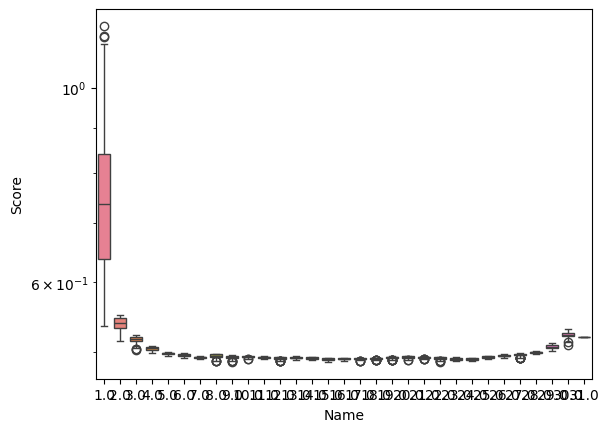

In [96]:
# Initialize a DataFrame to store the simulated data
sim_data = pd.DataFrame()

# For each row in the data, simulate a dataset and add it to sim_data
for idx, row in data.iterrows():
    # Use the normal distribution to simulate data
    if int(row["Name"]) > 0:
        simulated = np.random.normal(loc=row['mean_score'], scale=row['std_score'], size=1000)
        # Clip the simulated data at the min and max values
        simulated = np.clip(simulated, row['min_score'], row['max_score'])
        # Add the simulated data to the DataFrame
        sim_data[str(row['Name'])] = pd.Series(simulated)

# Plot a boxplot of the simulated data
# plt.figure(figsize=(10,6))
sns.boxplot(data=sim_data)
plt.xlabel('Name')
plt.ylabel('Score')
plt.yscale('log')
plt.show()


In [97]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
# Create a Box trace for each row in the data
# Create a Box trace for each 'Name' in the data
# Initialize a DataFrame to store the simulated data
# Create a Box trace for each row in the data
# Create a Box trace for each 'Name' in the data


# Create traces for data points 1 and 2
traces_1_2 = []
for idx, row in data.iterrows():
    if int(row['Name']) <= 1:
        traces_1_2.append(go.Box(
            y=[row['min_score'], row['mean_score'] - row['std_score'], row['mean_score'], row['mean_score'] + row['std_score'], row['max_score']],
            name=int(row['Name']),
            boxpoints=False,
            line_width=2,
        ))

# Create traces for data points 3 and above
traces_3_plus = []
for idx, row in data.iterrows():
    if int(row['Name']) > 1 and int(row['Name']) <= 28:
        traces_3_plus.append(go.Box(
            y=[row['min_score'], row['mean_score'] - row['std_score'], row['mean_score'], row['mean_score'] + row['std_score'], row['max_score']],
            name=int(row['Name']),
            boxpoints=False,
            line_width=2,
        ))

# Create a figure with two subplots
fig = make_subplots(rows=1, cols=2, subplot_titles=("k=1", "k>=2"))

# Add traces to the subplots
for trace in traces_1_2:
    fig.add_trace(trace, row=1, col=1)

for trace in traces_3_plus:
    fig.add_trace(trace, row=1, col=2)

# Update the layout
fig.update_layout(
    # title_text="Mean Squared Error for Different Number of Datasets (k)",
    
    yaxis_title='MSE',
    xaxis_title='k (number of contexts)',
    width=1200,  # Width of the figure in pixels
    # height=400,  # Height of the figure in pixels
    autosize=False,
    showlegend=False,
    margin=dict(l=0, r=10, t=50, b=50),
    font=dict(
        family="Arial",  # Font family
        size=20,  # Font size
    ),
    # yaxis=dict(
    #     title_font=dict(
    #         size=14,  # Y-axis title font size
    #     ),
    #     tickfont=dict(
    #         size=12,  # Y-axis tick font size
    #     ),
    # ),
    # xaxis=dict(
    #     tickfont=dict(
    #         size=12,  # X-axis tick font size
    #     ),
    # ),
)

# add y axis title for both subplots
fig.update_yaxes(title_text="MSE", row=1, col=2)
fig.update_xaxes(title_text="k (number of contexts)", row=1, col=2)
# log scale for y axis
# fig.update_yaxes(type="log")
# Save the figure as a PDF
fig.write_image("paper/k-study.pdf")
fig.show()




In [98]:
import pandas as pd
import plotly.express as px

# Load the data from the CSV file
data = pd.read_csv('loo-k=9.csv')
# transpose
# drop combination column
data = data.drop(columns=["combination"])
# drop the first column
data = data.drop(columns=["Unnamed: 0"])
# data = data.T
# Set the first row as the column names and remove it
# remove term gate-evolve-nn-k=14-loo- and .mean from Name
# split name into two columns using . as separator
# display_custom(data)
# rename second column to Score
# sort by score
# remove rows with nan values
data = data.dropna()
display_custom(data)



,missing_feature,mean,std,min,max
0,full,0.486597,0.070633,0.369885,0.572725
1,chexpert,0.504964,0.081244,0.382383,0.674583
2,clevr,0.524227,0.064272,0.408062,0.625004
3,diabetic,0.502025,0.079801,0.378684,0.660690
4,fungi,0.507159,0.096888,0.379358,0.725097
5,happy,0.499662,0.075439,0.366722,0.594813
6,kinetics,0.505206,0.084750,0.386570,0.689392
7,newyorkercaptioncontest,0.502386,0.077301,0.385880,0.652350
8,places365,0.503426,0.080396,0.387305,0.666548
9,ucf,0.501676,0.081359,0.375145,0.675420


In [99]:
# rename missing-feature column to Name
data = data.rename(columns={"missing_feature": "Name"})


# Now create the box plots
traces = []
for idx, row in data.iterrows():
    # Check if we have all necessary stats to plot
    if pd.notnull(row['min']) and pd.notnull(row['mean']) and pd.notnull(row['max']) and pd.notnull(row['std']):
        traces.append(go.Box(
            y=[row['min'], row['mean'] - row['std'], row['mean'], row['mean'] + row['std'], row['max']],
            name=row['Name'],
            boxpoints=False,
            line_width=2,
        ))

# Create the figure and add traces
fig = go.Figure(traces)
fig.show()
# save as pdf
fig.write_image("paper/loo-k=9.pdf")

In [100]:
# Calculate the difference from 'full' variant
# sort by mean_score
data = data.sort_values(by="mean", ascending=False)
display_custom(data)
# print a list of all items in Names
print(data["Name"].values)
full_score = data[data['Name'] == 'full']['mean'].values[0]
data['Score Difference'] = data['mean'] - full_score
# rename pokemonblipcaptions to pokemonblip
data["Name"] = data["Name"].str.replace("pokemonblipcaptions", "pokemonblip")
data["Name"] = data["Name"].str.replace("newyorkercaptioncontest", "nycc")
# drop row with Name=full
data = data[data.Name != 'full']
font_size = 13
# Create a line chart with markers using Plotly
fig = px.bar(data, x='Name', y='Score Difference', labels={'Name': 'Dataset Name', 'Score Difference':'Performance Loss (higher means more important feature)'})
fig.update_layout(
    # height=300,
    width=500,
    showlegend=False,
    font=dict(size=font_size),  # Global font size
    yaxis=dict(
        title_font=dict(size=font_size),  # Y-axis title font size
        tickfont=dict(size=font_size),  # Y-axis tick font size
    ),
    xaxis=dict(
        title_font=dict(size=font_size),  # X-axis title font size (if any)
        tickfont=dict(size=font_size),  # X-axis tick font size
    ),
    # margin=dict(l=20, r=20, t=20, b=20),  # margins
    
)

# Save the figure as a PDF file
fig.write_image("paper/k=9.pdf")
# Show the figure
fig.show()

,Name,mean,std,min,max
2,clevr,0.524227,0.064272,0.408062,0.625004
4,fungi,0.507159,0.096888,0.379358,0.725097
6,kinetics,0.505206,0.084750,0.386570,0.689392
1,chexpert,0.504964,0.081244,0.382383,0.674583
8,places365,0.503426,0.080396,0.387305,0.666548
7,newyorkercaptioncontest,0.502386,0.077301,0.385880,0.652350
3,diabetic,0.502025,0.079801,0.378684,0.660690
9,ucf,0.501676,0.081359,0.375145,0.675420
5,happy,0.499662,0.075439,0.366722,0.594813
0,full,0.486597,0.070633,0.369885,0.572725


['clevr' 'fungi' 'kinetics' 'chexpert' 'places365'
 'newyorkercaptioncontest' 'diabetic' 'ucf' 'happy' 'full']

In [101]:
import pandas as pd
import plotly.express as px

print(pd.__version__)
# Load the data from the CSV file
data = pd.read_csv('loo-k=15.csv')
# transpose
# drop combination column
data = data.drop(columns=["combination"])
# drop the first column
data = data.drop(columns=["Unnamed: 0"])
# data = data.T
# Set the first row as the column names and remove it
# remove term gate-evolve-nn-k=14-loo- and .mean from Name
# split name into two columns using . as separator
# display_custom(data)
# rename second column to Score
# sort by score
# remove rows with nan values
data = data.dropna()
display_custom(data)

# rename missing-feature column to Name
data = data.rename(columns={"missing_feature": "Name"})

# Calculate the difference from 'full' variant
# sort by mean_score
data = data.sort_values(by="mean", ascending=False)
full_score = data[data['Name'] == 'full']['mean'].values[0]
data['Score Difference'] = data['mean'] - full_score
# rename pokemonblipcaptions to pokemonblip
data["Name"] = data["Name"].str.replace("pokemonblipcaptions", "pokemonblip")
data["Name"] = data["Name"].str.replace("newyorkercaptioncontest", "nycc")
# add a new row with Name mean, in which all values are the mean of the column except the Name column
# set name to index
# means = data.select_dtypes(include=[np.number]).mean()

# means['Name'] = 'clevr-math' # Append Mean to Name column
# data.loc[len(data.index)] = means
# sort by score difference largest to smallest
data = data.sort_values(by="Score Difference", ascending=False)
# drop the row with Name full
data = data[data.Name != 'full']
# add new row with mean values
font_size = 13
# Create a line chart with markers using Plotly
fig = px.bar(data, x='Name', y='Score Difference', labels={'Name': 'Dataset Name', 'Score Difference':'Performance Loss (higher means more important feature)'})
fig.update_layout(
    # height=300,
    width=700,
    showlegend=False,
    font=dict(size=font_size),  # Global font size
    yaxis=dict(
        title_font=dict(size=font_size),  # Y-axis title font size
        tickfont=dict(size=font_size),  # Y-axis tick font size
    ),
    xaxis=dict(
        title_font=dict(size=font_size),  # X-axis title font size (if any)
        tickfont=dict(size=font_size),  # X-axis tick font size
    ),
    # margin=dict(l=20, r=20, t=20, b=20),  # margins
    
)

# Save the figure as a PDF file
fig.write_image("paper/k-15.pdf")
# Show the figure
fig.show()

2.2.2

,missing_feature,mean,std,min,max
0,full,0.413060,0.084721,0.274182,0.569785
1,ade20k,0.423140,0.096956,0.274755,0.618858
2,aircraft,0.425551,0.094288,0.276014,0.619468
3,chexpert,0.424550,0.091850,0.281449,0.595731
4,clevr,0.436812,0.091933,0.278560,0.592840
5,coco-164k,0.428054,0.102674,0.276472,0.654027
6,diabetic,0.433669,0.111227,0.270621,0.661967
7,food101,0.428675,0.100938,0.278994,0.639961
8,fungi,0.429376,0.098592,0.271012,0.645340
9,happy,0.434394,0.099494,0.285258,0.661443


In [102]:
import pandas as pd
import plotly.express as px

# Load the data from the CSV file
data = pd.read_csv('k=1.csv')

# transpose
# rename combination to Name
data = data.rename(columns={"combination": "Name"})
# drop the first column
data = data.drop(columns=["Unnamed: 0"])
data["Name"] = data["Name"].str.replace("newyorkercaptioncontest", "nycc")


# remove _score from column names
data.columns = data.columns.str.replace('_score', '')
# data = data.T
# Set the first row as the column names and remove it
# remove term gate-evolve-nn-k=14-loo- and .mean from Name
# split name into two columns using . as separator
# display_custom(data)
# rename second column to Score
# sort by score
# remove rows with nan values
data = data.dropna()
display_custom(data)

# sort by avg column
data = data.sort_values(by="avg", ascending=True)
fig = px.bar(data, x='Name', y='avg', labels={'Name': 'Dataset Name', 'avg':'DGPM in MSE (lower is better)'})
fig.update_layout(
    # height=300,
    width=700,
    showlegend=False,
    font=dict(size=font_size),  # Global font size
    yaxis=dict(
        title_font=dict(size=font_size),  # Y-axis title font size
        tickfont=dict(size=font_size),  # Y-axis tick font size
    ),
    xaxis=dict(
        title_font=dict(size=font_size),  # X-axis title font size (if any)
        tickfont=dict(size=font_size),  # X-axis tick font size
    ),
    # margin=dict(l=20, r=20, t=20, b=20),  # margins
    
)

# Save the figure as a PDF file
fig.write_image("paper/k=1.pdf")
# Show the figure
fig.show()

,avg,min,max,std,Name
0,0.535267,0.471562,0.775079,0.093469,ade20k
1,0.538904,0.404619,1.055010,0.185827,flickr30k
2,0.548324,0.434568,0.993026,0.161244,coco-164k
3,0.553381,0.436459,0.849555,0.113288,nycc
4,0.562468,0.444323,0.640304,0.068262,chexpert
5,0.571077,0.470712,0.641148,0.056208,diabetic
6,0.571635,0.452742,0.678254,0.077096,ham10k
7,0.609167,0.526345,0.741686,0.060690,happy
8,0.620404,0.417982,0.918906,0.156578,ucf
9,0.638522,0.427780,0.868759,0.132468,cifar100


In [103]:
sub_gate_columns = data["Name"]

sub_gate_columns = sub_gate_columns[1:]
sub_gate_columns = ["newyorkercaptioncontest" if col == "nycc" else col for col in sub_gate_columns]
print(sub_gate_columns)


[
    'flickr30k',
    'coco-164k',
    'newyorkercaptioncontest',
    'chexpert',
    'diabetic',
    'ham10k',
    'happy',
    'ucf',
    'cifar100',
    'iwildcam',
    'clevr',
    'pascal',
    'food101',
    'places365',
    'cityscapes',
    'coco-10k',
    'aircraft',
    'acdc',
    'vgg',
    'fungi',
    'cubirds',
    'mini',
    'hmdb51',
    'clevr-math',
    'imagenet1k',
    'kinetics',
    'omniglot',
    'dtextures',
    'nyu',
    'winoground'
]

In [104]:
import pathlib
import pandas as pd
import yaml
from rich import print

def load_data_as_df(filepath):
    df = pd.read_csv(filepath)
    task_dataset_dict = yaml.safe_load(open("task_to_metric_mapping_opt.yaml"))

    
    # replace NA with 5
    # df = df.fillna(5)
    df = df.rename(columns={"Unnamed: 0": "model_name"})
    # if a columne has testing/ensemble_3/ in it then rename it to replace testing/ensemble_3/ with ''
    df.columns = df.columns.str.replace("testing/ensemble_3/", "")
    # if any columns with the keyword "loss" are larger than 10, set them to the value of 10
    loss_columns = df.columns[df.columns.str.contains('loss', case=False)]
    # for col in loss_columns:
    #     df[col] = df[col].apply(lambda x: 10 if x > 10 else x)
        
    
    
    
    columns = df.columns.tolist()[1:]
    model_names = df.columns.tolist()[0]
    # remove all datapoints with less than 50% on imagenet1k.1

    # Replace NA with 5
    # df = df.fillna(1)
    # model_names = df[model_names][1:]

    # Convert all columns (except the first) to numeric
    for col in df.columns[1:]:
        df[col] = pd.to_numeric(df[col], errors="coerce")
    
    # All columns that have mae in the name should be divided by 5 and then the result should be subtracted from 1 and multiplied by 100
    mae_columns = df.columns[df.columns.str.contains('dice', case=False)]
    for col in mae_columns:
        df[col] = (1-df[col]) #* 100
    
    # columns with mae or loss in their name (except those with dice loss) should be divided by 4 and then the result should be subtracted from 1 and multiplied by 100
    
    selected_columns = df.columns[df.columns.str.contains('mae|loss|bs', case=False) & ~df.columns.str.contains('dice', case=False)]
    for col in selected_columns:
        df[col] = - df[col]

    # if column has no dice, mae, loss, bs in it, then check if it is less than 1, if so multiply by 100
    selected_columns = df.columns[~df.columns.str.contains('mae|loss|bs|dice|name', case=False)]
    for col in selected_columns:
        if df[col].max() < 1:
            df[col] = df[col] * 100
    
    # for all columns except those with name in them, detect outliers and replace them with max + 10% of max
    # outliers should be detected using the 1.5*IQR rule
    selected_columns = df.columns[~df.columns.str.contains('name', case=False)]
    for col in selected_columns:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        # print(df[col] > upper_bound)
        df[col] = df[col].apply(lambda x: upper_bound if x > upper_bound else x)
        df[col] = df[col].apply(lambda x: lower_bound if x < lower_bound else x)
    
    # for col in df.columns[1:]:
    #     if df[col].max() < 1:  # Check if the column is in a fractional format
    #         df[col] = df[col] * 100  # Convert to percentage format
    
    
    # for col in columns:
    #     df[col] = (df[col] - df[col].min())
    
    # gaussian normalization
    # for col in columns:
    #     df[col] = (df[col] - df[col].mean()) / df[col].std()
    
    # Add a new column for each task, where the value is the mean of the columns that are in the task
    columns = df.columns.tolist()
    columns = sorted(columns)
    dataset_to_task_dict = {item: k for k, v in task_dataset_dict.items() for item in v}
    
    for task, datasets in task_dataset_dict.items():
        metrics_matching_datasets = [col for col in columns if any([dataset in col for dataset in datasets])]
        df[task] = df[metrics_matching_datasets].mean(axis=1)
    
    return df

source_csv_filepath = (
    "19042024_df.csv"
)
source_csv_filepath = pathlib.Path(source_csv_filepath)

df = load_data_as_df(source_csv_filepath)
display_custom(df)


/var/folders/gh/_5t3nhn94t12m7rh483b8b7r0000gn/T/ipykernel_41440/3621468232.py:85: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/var/folders/gh/_5t3nhn94t12m7rh483b8b7r0000gn/T/ipykernel_41440/3621468232.py:85: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/var/folders/gh/_5t3nhn94t12m7rh483b8b7r0000gn/T/ipykernel_41440/3621468232.py:85: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd

,model_name,acdc.mIoU,acdc.overall_accuracy,acdc.mean_accuracy,acdc.dice_loss,ade20k.mean_accuracy,ade20k.mIoU,ade20k.focal_loss,ade20k.loss,ade20k.overall_accuracy,ade20k.dice_loss,ade20k.ce_loss,cityscapes.focal_loss,cityscapes.ce_loss,cityscapes.mIoU,cityscapes.overall_accuracy,cityscapes.loss,coco-10k.loss,coco-10k.ce_loss,coco-10k.focal_loss,coco-10k.mean_accuracy,coco-10k.dice_loss,coco-10k.mIoU,coco-10k.overall_accuracy,coco-164k.focal_loss,coco-164k.mean_accuracy,coco-164k.mIoU,coco-164k.ce_loss,coco-164k.overall_accuracy,coco-164k.dice_loss,coco-164k.loss,nyu.focal_loss,nyu.loss,nyu.ce_loss,nyu.dice_loss,nyu.mean_accuracy,nyu.mIoU,nyu.overall_accuracy,pascal.loss,pascal.overall_accuracy,pascal.focal_loss,pascal.mean_accuracy,pascal.dice_loss,pascal.ce_loss,pascal.mIoU,aircraft.accuracy_top_1,aircraft.loss,chexpert.loss,chexpert.2-aps,chexpert.bs-macro,chexpert.0-auc,chexpert.3-bs,chexpert.0-bs,chexpert.1-bs,chexpert.1-aps,chexpert.0-aps,chexpert.3-auc,chexpert.4-auc,chexpert.1-auc,chexpert.aps-macro,chexpert.auc-macro,chexpert.2-auc,chexpert.4-bs,chexpert.3-aps,chexpert.4-aps,chexpert.2-bs,cifar100.loss,cifar100.accuracy_top_1,cifar100.accuracy_top_5,clevr.loss_material,clevr.accuracy_top_1_shape,clevr.loss_yes_no,clevr.accuracy_top_1_material,clevr.accuracy_top_1,clevr.accuracy_top_1_count,clevr.accuracy_top_1_size,clevr.loss,clevr.loss_shape,clevr.accuracy_top_1_colour,clevr.accuracy_top_1_yes_no,clevr.loss_size,clevr.loss_count,clevr.loss_colour,clevr-math.loss,clevr-math.accuracy_top_5,clevr-math.accuracy_top_1,cubirds.accuracy_top_1,cubirds.loss,diabetic.loss,diabetic.0-bs,diabetic.3-auc,diabetic.4-aps,diabetic.0-auc,diabetic.auc-macro,diabetic.3-bs,diabetic.4-bs,diabetic.2-bs,diabetic.1-auc,diabetic.3-aps,diabetic.bs-macro,diabetic.2-auc,diabetic.aps-macro,diabetic.1-bs,diabetic.1-aps,diabetic.0-aps,diabetic.2-aps,diabetic.4-auc,dtextures.accuracy_top_1,dtextures.loss,flickr30k.image_to_text_accuracy,flickr30k.loss,flickr30k.image_to_text_loss,flickr30k.image_to_text_accuracy_top_5,flickr30k.text_to_image_accuracy_top_5,flickr30k.text_to_image_accuracy,flickr30k.text_to_image_loss,food101.accuracy_top_1,food101.accuracy_top_5,food101.loss,fungi.loss,fungi.accuracy_top_1,ham10k.2-auc,ham10k.5-auc,ham10k.aps-macro,ham10k.6-bs,ham10k.auc-macro,ham10k.0-bs,ham10k.4-aps,ham10k.0-auc,ham10k.1-auc,ham10k.4-bs,ham10k.0-aps,ham10k.5-aps,ham10k.6-aps,ham10k.3-aps,ham10k.2-aps,ham10k.3-auc,ham10k.6-auc,ham10k.1-aps,ham10k.loss,ham10k.2-bs,ham10k.bs-macro,ham10k.5-bs,ham10k.1-bs,ham10k.3-bs,ham10k.4-auc,happy.accuracy_top_5,happy.loss_individual,happy.accuracy_top_1,happy.loss_species,happy.accuracy_top_1_individual,happy.accuracy_top_1_species,happy.loss,happy.accuracy_top_5_individual,happy.accuracy_top_5_species,hmdb51.accuracy_top_5,hmdb51.loss,hmdb51.accuracy_top_1,imagenet1k.accuracy_top_1,imagenet1k.accuracy_top_5,imagenet1k.loss,iwildcam.mse_loss,iwildcam.mae_loss,iwildcam.loss,kinetics.accuracy_top_1,kinetics.accuracy_top_5,kinetics.loss,mini.accuracy_top_1,mini.loss,newyorkercaptioncontest.image_to_text_accuracy_top_5,newyorkercaptioncontest.text_to_image_accuracy,newyorkercaptioncontest.loss,newyorkercaptioncontest.image_to_text_loss,newyorkercaptioncontest.text_to_image_loss,newyorkercaptioncontest.text_to_image_accuracy_top_5,newyorkercaptioncontest.image_to_text_accuracy,omniglot.accuracy_top_1,omniglot.loss,places365.accuracy_top_5,places365.accuracy_top_1,places365.loss,pokemonblipcaptions.text_to_image_accuracy_top_5,pokemonblipcaptions.text_to_image_accuracy,pokemonblipcaptions.image_to_text_loss,pokemonblipcaptions.loss,pokemonblipcaptions.image_to_text_accuracy_top_5,pokemonblipcaptions.image_to_text_accuracy,pokemonblipcaptions.text_to_image_loss,ucf.accuracy_top_1,ucf.loss,ucf.accuracy_top_5,vgg.accuracy_top_1,vgg.loss,winoground.image_to_text_loss,winoground.image_to_text_accuracy,winoground.text_to_image_loss,winoground.loss,winoground.text_to_image_accuracy,Image Classification,Few Shot Image Classi

In [105]:
def move_column(df, column_name, position):
    """
    Move a specific column to a specified position in a DataFrame.

    Parameters:
    df (pandas.DataFrame): The DataFrame to modify.
    column_name (str): The name of the column to move.
    position (int): The position to move the column to.

    Returns:
    pandas.DataFrame: The modified DataFrame.
    """
    # Ensure the position is within the valid range
    if position < 0 or position > len(df.columns):
        raise ValueError(f"Position must be between 0 and {len(df.columns)}")

    # Get a list of the column names
    cols = df.columns.tolist()

    # Check if the column name is in the list
    if column_name in cols:
        # Remove the column from its current position
        cols.remove(column_name)

        # Insert the column at the specified position
        cols.insert(position, column_name)

        # Reorder the DataFrame
        df = df[cols]

    return df

In [106]:
import yaml

task_to_dataset_metrics = yaml.safe_load(open("task_to_metric_mapping_opt.yaml"))
idx = 1
for task_name, dataset_metrics in task_to_dataset_metrics.items():
    for metric in dataset_metrics:
        df = move_column(df, metric, idx)
        idx += 1
print(task_to_dataset_metrics)

{
    'Image Classification': [
        'imagenet1k.accuracy_top_1-epoch-mean',
        'imagenet1k.accuracy_top_5-epoch-mean',
        'imagenet1k.loss-epoch-mean',
        'cifar100.accuracy_top_1-epoch-mean',
        'cifar100.accuracy_top_5-epoch-mean',
        'cifar100.loss-epoch-mean',
        'food101.accuracy_top_1-epoch-mean',
        'food101.accuracy_top_5-epoch-mean',
        'food101.loss-epoch-mean',
        'happy.loss_individual-epoch-mean',
        'happy.loss_species-epoch-mean',
        'happy.accuracy_top_1_individual-epoch-mean',
        'happy.accuracy_top_1_species-epoch-mean',
        'happy.accuracy_top_5_individual-epoch-mean',
        'happy.accuracy_top_5_species-epoch-mean',
        'places365.accuracy_top_1-epoch-mean',
        'places365.accuracy_top_5-epoch-mean',
        'places365.loss-epoch-mean'
    ],
    'Few Shot Image Classification': [
        'aircraft.accuracy_top_1-epoch-mean',
        'aircraft.loss-epoch-mean',
        'cubirds.accuracy_top_1-epoch-mean',
        'cubirds.loss-epoch-mean',
        'dtextures.accuracy_top_1-epoch-mean',
        'dtextures.loss-epoch-mean',
        'fungi.accuracy_top_1-epoch-mean',
        'fungi.loss-epoch-mean',
        'mini.accuracy_top_1-epoch-mean',
        'mini.loss-epoch-mean',
        'omniglot.accuracy_top_1-epoch-mean',
        'omniglot.loss-epoch-mean',
        'vgg.accuracy_top_1-epoch-mean',
        'vgg.loss-epoch-mean'
    ],
    'Image Relational Reasoning': [
        'clevr.accuracy_top_1_shape-epoch-mean',
        'clevr.accuracy_top_1_material-epoch-mean',
        'clevr.accuracy_top_1_count-epoch-mean',
        'clevr.accuracy_top_1_size-epoch-mean',
        'clevr.accuracy_top_1_colour-epoch-mean',
        'clevr.accuracy_top_1_yes_no-epoch-mean',
        'clevr.loss_shape-epoch-mean',
        'clevr.loss_material-epoch-mean',
        'clevr.loss_count-epoch-mean',
        'clevr.loss_size-epoch-mean',
        'clevr.loss_colour-epoch-mean',
        'clevr.loss_yes_no-epoch-mean',
        'clevr-math.accuracy_top_5-epoch-mean',
        'clevr-math.accuracy_top_1-epoch-mean',
        'clevr-math.loss-epoch-mean'
    ],
    'Image Segmentation': [
        'ade20k.mean_accuracy',
        'ade20k.mIoU',
        'ade20k.focal_loss-epoch-mean',
        'ade20k.overall_accuracy',
        'ade20k.ce_loss-epoch-mean',
        'cityscapes.focal_loss-epoch-mean',
        'cityscapes.ce_loss-epoch-mean',
        'cityscapes.dice_loss-epoch-mean',
        'cityscapes.mIoU',
        'cityscapes.overall_accuracy',
        'cityscapes.loss-epoch-mean',
        'coco-10k.loss-epoch-mean',
        'coco-10k.ce_loss-epoch-mean',
        'coco-10k.focal_loss-epoch-mean',
        'coco-10k.mean_accuracy',
        'coco-10k.dice_loss-epoch-mean',
        'coco-10k.mIoU',
        'coco-10k.overall_accuracy',
        'coco-164k.focal_loss-epoch-mean',
        'coco-164k.mean_accuracy',
        'coco-164k.mIoU',
        'coco-164k.ce_loss-epoch-mean',
        'coco-164k.overall_accuracy',
        'coco-164k.dice_loss-epoch-mean',
        'coco-164k.loss-epoch-mean',
        'nyu.focal_loss-epoch-mean',
        'nyu.loss-epoch-mean',
        'nyu.ce_loss-epoch-mean',
        'nyu.dice_loss-epoch-mean',
        'nyu.mean_accuracy',
        'nyu.mIoU',
        'nyu.overall_accuracy',
        'pascal.loss-epoch-mean',
        'pascal.overall_accuracy',
        'pascal.focal_loss-epoch-mean',
        'pascal.mean_accuracy',
        'pascal.dice_loss-epoch-mean',
        'pascal.ce_loss-epoch-mean',
        'pascal.mIoU'
    ],
    'Image to Text Zero Shot Learning': [
        'flickr30k.image_to_text_accuracy-epoch-mean',
        'flickr30k.loss-epoch-mean',
        'flickr30k.image_to_text_loss-epoch-mean',
        'flickr30k.image_to_text_accuracy_top_5-epoch-mean',
        'flickr30k.text_to_image_accuracy_top_5-epoch-mean',
        'flickr30k.text_to_image_accuracy-epoch-mean',
        'flickr30k.text_to_image_loss-epoch-mean',
        'newyorkercapt

In [107]:
modality_shift = ["bart", "bert", "whisper", "mpnet"]
pretraining_shift = ["ar-vit-b16", "clip-b16", "dino-b16", "deit3-b16", "flex-b-1200ep", "laion-b16", "siglip-p16"]
architecture_shift = ["ar-vit-b16", "convnextv2-base", "effv2-rw-s", "rnx50-32x4a1", "svit-b16", "effformer-s0"]
print(df["model_name"])

0            clip-b16
1          ar-vit-b16
2           deit3-b16
3            dino-b16
4          effv2-rw-s
5           laion-b16
6        rnx50-32x4a1
7          siglip-p16
8            svit-b16
9       flex-b-1200ep
10               bart
11               bert
12    convnextv2-base
13       effformer-s0
14              mpnet
15            whisper
Name: model_name, dtype: object

In [108]:
import numpy as np

def generate_palette(palette, target_length):
    if len(palette) >= target_length:
        return palette[:target_length]
    else:
        # Interpolate colors in the palette
        colors = np.array([px.colors.hex_to_rgb(color) for color in palette])
        new_colors = np.array([
            np.interp(np.linspace(0, len(colors) - 1, target_length), np.arange(len(colors)), colors[:, i])
            for i in range(3)
        ]).T.astype(int)
        return [f'rgb({r},{g},{b})' for r, g, b in new_colors]

In [109]:
import plotly.express as px
import plotly.graph_objects as go
# Preprocess data for polar plot
color_palette = px.colors.sequential.Magma_r  # Original palette
target_length = len(architecture_shift)
color_palette = generate_palette(color_palette, target_length)

categories = df.columns[-8:]  # Exclude the first column (Model.Metric)
values = df.iloc[:, -8:].values  # Exclude the first column

categories = [category.replace("Classification", "Class").replace("Zero Shot", "ZS").replace("Image", "Img").replace("Regression", "Reg").replace("Few Shot", "FS").replace("Segmentation", "Seg") for category in categories]  # Shorten the category names
# dataframe that includes only Model.Metrics matching entries in pretraining_shift
new_df = df[df['model_name'].isin(architecture_shift)]
columns = new_df.columns
# gaussian normalization
# for col in columns[1:]:
#     new_df[col] = (new_df[col] - new_df[col].mean()) / (new_df[col].std())
values = new_df.iloc[:, -8:].values  # Exclude the first column
new_df = new_df.reset_index(drop=True)
# Create polar plot for each model
fig = go.Figure()
for i, model in enumerate(architecture_shift):
    id = new_df[new_df['model_name'] == model].index[0]
    color_index = i % len(color_palette)  # Ensure the index is within the range of the color palette
    fig.add_trace(go.Scatterpolar(
        r=values[i],
        theta=categories,
        name=model,
        mode='lines',
        line=dict(color=color_palette[color_index])  
        
    ))
    fig.add_trace(go.Scatterpolar(
        r=[values[i][0], values[i][-1]],
        theta=[categories[0], categories[-1]],
        name=model,
        mode='lines',
        showlegend=False,
        line=dict(color=color_palette[color_index]) 
        
    ))
    
    

# Update layout
fig.update_layout(
    height=400,
    width=400,
    autosize=True,
    margin=dict(
            l=50,
            r=50,
            b=50,
            t=100,
            pad=4
        ),
    font=dict(
        size=8
    ),
    polar=dict(
        radialaxis=dict(
            range=[0, 100]  # This sets the range to be from 0 to 100
        )
    )
)

# make legend smaller and move it to the top center
fig.update_layout(
    legend=dict(
        orientation="h",
        yanchor="top",
        y=1.4,
        xanchor="center",
        x=0.5
    )
)

fig.show()
fig.write_image("architecture_polar_plot.pdf")
fig.write_image("architecture_polar_plot.png")

In [110]:
import plotly.express as px
# Preprocess data for polar plot
color_palette = px.colors.sequential.Magma_r  # Original palette
target_length = len(pretraining_shift)
color_palette = generate_palette(color_palette, target_length)

categories = df.columns[-8:]  # Exclude the first column (Model.Metric)
values = df.iloc[:, -8:].values  # Exclude the first column

categories = [category.replace("Classification", "Class").replace("Zero Shot", "ZS").replace("Image", "Img").replace("Regression", "Reg").replace("Few Shot", "FS").replace("Segmentation", "Seg") for category in categories]  # Shorten the category names
# dataframe that includes only Model.Metrics matching entries in pretraining_shift
new_df = df[df['model_name'].isin(pretraining_shift)]
columns = new_df.columns
# gaussian normalization
# for col in columns[1:]:
#     new_df[col] = (new_df[col] - new_df[col].mean()) / new_df[col].std()
values = new_df.iloc[:, -8:].values  # Exclude the first column
new_df = new_df.reset_index(drop=True)
# Create polar plot for each model
fig = go.Figure()
for i, model in enumerate(pretraining_shift):
    id = new_df[new_df['model_name'] == model].index[0]
    color_index = i % len(color_palette)  # Ensure the index is within the range of the color palette
    fig.add_trace(go.Scatterpolar(
        r=values[i],
        theta=categories,
        name=model,
        mode='lines',
        line=dict(color=color_palette[color_index])  
        
    ))
    fig.add_trace(go.Scatterpolar(
        r=[values[i][0], values[i][-1]],
        theta=[categories[0], categories[-1]],
        name=model,
        mode='lines',
        showlegend=False,
        line=dict(color=color_palette[color_index]) 
        
    ))
    
    

# Update layout
fig.update_layout(
    height=400,
    width=400,
    autosize=True,
    margin=dict(
            l=50,
            r=50,
            b=50,
            t=100,
            pad=4
        ),
    font=dict(
        size=8
    ),
    polar=dict(
        radialaxis=dict(
            range=[0, 100]  # This sets the range to be from 0 to 100
        )
    )
)

# make legend smaller and move it to the top center
fig.update_layout(
    legend=dict(
        orientation="h",
        yanchor="top",
        y=1.4,
        xanchor="center",
        x=0.5
    )
)

fig.show()
fig.write_image("pretraining_polar_plot.pdf")
fig.write_image("pretraining_polar_plot.png")

In [111]:
import plotly.express as px
# Preprocess data for polar plot
color_palette = px.colors.sequential.Magma_r  # Original palette
target_length = len(modality_shift)
color_palette = generate_palette(color_palette, target_length)

categories = df.columns[-8:]  # Exclude the first column (Model.Metric)
values = df.iloc[:, -8:].values  # Exclude the first column

categories = [category.replace("Classification", "Class").replace("Zero Shot", "ZS").replace("Image", "Img").replace("Regression", "Reg").replace("Few Shot", "FS").replace("Segmentation", "Seg") for category in categories]  # Shorten the category names
# dataframe that includes only Model.Metrics matching entries in pretraining_shift
new_df = df[df['model_name'].isin(modality_shift)]
columns = new_df.columns
# gaussian normalization
# for col in columns[1:]:
#     new_df[col] = (new_df[col] - new_df[col].mean()) / new_df[col].std()
values = new_df.iloc[:, -8:].values  # Exclude the first column
new_df = new_df.reset_index(drop=True)
# Create polar plot for each model
fig = go.Figure()
for i, model in enumerate(modality_shift):
    id = new_df[new_df['model_name'] == model].index[0]
    color_index = i % len(color_palette)  # Ensure the index is within the range of the color palette
    fig.add_trace(go.Scatterpolar(
        r=values[i],
        theta=categories,
        name=model,
        mode='lines',
        line=dict(color=color_palette[color_index])  
        
    ))
    fig.add_trace(go.Scatterpolar(
        r=[values[i][0], values[i][-1]],
        theta=[categories[0], categories[-1]],
        name=model,
        mode='lines',
        showlegend=False,
        line=dict(color=color_palette[color_index]) 
        
    ))
    
    

# Update layout
fig.update_layout(
    height=400,
    width=400,
    autosize=True,
    margin=dict(
            l=50,
            r=50,
            b=50,
            t=100,
            pad=4
        ),
    font=dict(
        size=8
    ),
    polar=dict(
        radialaxis=dict(
            range=[0, 100]  # This sets the range to be from 0 to 100
        )
    )
)

# make legend smaller and move it to the top center
fig.update_layout(
    legend=dict(
        orientation="h",
        yanchor="top",
        y=1.4,
        xanchor="center",
        x=0.5
    )
)

fig.show()
fig.write_image("modality_polar_plot.pdf")
fig.write_image("modality_polar_plot.png")

In [112]:
column_names = list(df.columns)

print(column_names)

[
    'model_name',
    'acdc.dice_loss',
    'ade20k.focal_loss',
    'ade20k.loss',
    'ade20k.dice_loss',
    'ade20k.ce_loss',
    'cityscapes.focal_loss',
    'cityscapes.ce_loss',
    'cityscapes.loss',
    'coco-10k.loss',
    'coco-10k.ce_loss',
    'coco-10k.focal_loss',
    'coco-10k.dice_loss',
    'coco-164k.focal_loss',
    'coco-164k.ce_loss',
    'coco-164k.dice_loss',
    'coco-164k.loss',
    'nyu.focal_loss',
    'nyu.loss',
    'nyu.ce_loss',
    'nyu.dice_loss',
    'pascal.loss',
    'pascal.focal_loss',
    'pascal.dice_loss',
    'pascal.ce_loss',
    'aircraft.accuracy_top_1',
    'aircraft.loss',
    'ade20k.mean_accuracy',
    'ade20k.mIoU',
    'ade20k.overall_accuracy',
    'cityscapes.mIoU',
    'cityscapes.overall_accuracy',
    'coco-10k.mean_accuracy',
    'coco-10k.mIoU',
    'coco-10k.overall_accuracy',
    'cifar100.loss',
    'cifar100.accuracy_top_1',
    'coco-164k.mean_accuracy',
    'cifar100.accuracy_top_5',
    'coco-164k.mIoU',
    'clevr.loss_material',
    'clevr.accuracy_top_1_shape',
    'coco-164k.overall_accuracy',
    'clevr.loss_yes_no',
    'clevr.accuracy_top_1_material',
    'clevr.accuracy_top_1',
    'clevr.accuracy_top_1_count',
    'clevr.accuracy_top_1_size',
    'clevr.loss',
    'clevr.loss_shape',
    'nyu.mean_accuracy',
    'clevr.accuracy_top_1_colour',
    'nyu.mIoU',
    'clevr.accuracy_top_1_yes_no',
    'nyu.overall_accuracy',
    'clevr.loss_size',
    'clevr.loss_count',
    'pascal.overall_accuracy',
    'clevr.loss_colour',
    'clevr-math.loss',
    'pascal.mean_accuracy',
    'clevr-math.accuracy_top_5',
    'clevr-math.accuracy_top_1',
    'cubirds.accuracy_top_1',
    'pascal.mIoU',
    'cubirds.loss',
    'dtextures.accuracy_top_1',
    'dtextures.loss',
    'flickr30k.image_to_text_accuracy',
    'flickr30k.loss',
    'flickr30k.image_to_text_loss',
    'flickr30k.image_to_text_accuracy_top_5',
    'flickr30k.text_to_image_accuracy_top_5',
    'chexpert.loss',
    'flickr30k.text_to_image_accuracy',
    'chexpert.2-aps',
    'flickr30k.text_to_image_loss',
    'chexpert.bs-macro',
    'food101.accuracy_top_1',
    'chexpert.0-auc',
    'food101.accuracy_top_5',
    'chexpert.3-bs',
    'food101.loss',
    'chexpert.0-bs',
    'fungi.loss',
    'chexpert.1-bs',
    'fungi.accuracy_top_1',
    'chexpert.1-aps',
    'chexpert.0-aps',
    'chexpert.3-auc',
    'chexpert.4-auc',
    'chexpert.1-auc',
    'chexpert.aps-macro',
    'chexpert.auc-macro',
    'chexpert.2-auc',
    'chexpert.4-bs',
    'chexpert.3-aps',
    'chexpert.4-aps',
    'chexpert.2-bs',
    'diabetic.loss',
    'diabetic.0-bs',
    'diabetic.3-auc',
    'diabetic.4-aps',
    'diabetic.0-auc',
    'diabetic.auc-macro',
    'diabetic.3-bs',
    'diabetic.4-bs',
    'diabetic.2-bs',
    'diabetic.1-auc',
    'diabetic.3-aps',
    'diabetic.bs-macro',
    'diabetic.2-auc',
    'diabetic.aps-macro',
    'happy.accuracy_top_5',
    'diabetic.1-bs',
    'happy.loss_individual',
    'diabetic.1-aps',
    'happy.accuracy_top_1',
    'diabetic.0-aps',
    'happy.loss_species',
    'diabetic.2-aps',
    'happy.accuracy_top_1_individual',
    'diabetic.4-auc',
    'happy.accuracy_top_1_species',
    'ham10k.2-auc',
    'happy.loss',
    'ham10k.5-auc',
    'happy.accuracy_top_5_individual',
    'ham10k.aps-macro',
    'happy.accuracy_top_5_species',
    'ham10k.6-bs',
    'hmdb51.accuracy_top_5',
    'ham10k.auc-macro',
    'hmdb51.loss',
    'ham10k.0-bs',
    'hmdb51.accuracy_top_1',
    'ham10k.4-aps',
    'imagenet1k.accuracy_top_1',
    'ham10k.0-auc',
    'imagenet1k.accuracy_top_5',
    'ham10k.1-auc',
    'imagenet1k.loss',
    'ham10k.4-bs',
    'iwildcam.mse_loss',
    'ham10k.0-aps',
    'iwildcam.mae_loss',
    'ham10k.5-aps',
    'iwildcam.loss',
    'ham10k.6-aps',
    'kinetics.accuracy_top_1',
    'ham10k.3-aps',
    'kinetics.accuracy_top_5',
    'ham10k.2-aps',
    'kinetics.loss',
    'ham10k.3-auc',
    'mini.accuracy_top_1',
    'ham10k.6-auc',
    'mini.loss',
    'ham10k.

In [113]:
import yaml


task_to_dataset = yaml.safe_load(open("task_mapping2.yaml"))
task_to_metric = {}
for key, datasets in task_to_dataset.items():
    task_to_metric[key] = []
    for dataset in datasets:
        for metric in df.columns:
            if dataset in metric:
                task_to_metric[key].append(metric)

task_to_metric = {k: [d for d in v if d in df.columns] for k, v in task_to_metric.items()}
dataset_to_weight = {}
for task_name, task_datasets in task_to_metric.items():
    for dataset in task_datasets:
        dataset_to_weight[dataset] = 1. / len(task_datasets) / len(task_to_metric)
print(task_to_metric)
# store task to metric mapping in a yaml file
with open("task_to_metric_mapping.yaml", "w") as file:
    yaml.dump(task_to_metric, file)
print(dataset_to_weight)
print(f"Sum of weights: {sum(dataset_to_weight.values())}")

{
    'Image Classification': [
        'cifar100.loss',
        'cifar100.accuracy_top_1',
        'cifar100.accuracy_top_5',
        'food101.accuracy_top_1',
        'food101.accuracy_top_5',
        'food101.loss',
        'happy.accuracy_top_5',
        'happy.loss_individual',
        'happy.accuracy_top_1',
        'happy.loss_species',
        'happy.accuracy_top_1_individual',
        'happy.accuracy_top_1_species',
        'happy.loss',
        'happy.accuracy_top_5_individual',
        'happy.accuracy_top_5_species',
        'imagenet1k.accuracy_top_1',
        'imagenet1k.accuracy_top_5',
        'imagenet1k.loss',
        'places365.accuracy_top_5',
        'places365.accuracy_top_1',
        'places365.loss'
    ],
    'Few Shot Image Classification': [
        'aircraft.accuracy_top_1',
        'aircraft.loss',
        'cubirds.accuracy_top_1',
        'cubirds.loss',
        'dtextures.accuracy_top_1',
        'dtextures.loss',
        'fungi.loss',
        'fungi.accuracy_top_1',
        'mini.accuracy_top_1',
        'mini.loss',
        'omniglot.accuracy_top_1',
        'omniglot.loss',
        'vgg.accuracy_top_1',
        'vgg.loss'
    ],
    'Image Segmentation': [
        'ade20k.focal_loss',
        'ade20k.loss',
        'ade20k.dice_loss',
        'ade20k.ce_loss',
        'ade20k.mean_accuracy',
        'ade20k.mIoU',
        'ade20k.overall_accuracy',
        'cityscapes.focal_loss',
        'cityscapes.ce_loss',
        'cityscapes.loss',
        'cityscapes.mIoU',
        'cityscapes.overall_accuracy',
        'coco-10k.loss',
        'coco-10k.ce_loss',
        'coco-10k.focal_loss',
        'coco-10k.dice_loss',
        'coco-164k.focal_loss',
        'coco-164k.ce_loss',
        'coco-164k.dice_loss',
        'coco-164k.loss',
        'coco-10k.mean_accuracy',
        'coco-10k.mIoU',
        'coco-10k.overall_accuracy',
        'coco-164k.mean_accuracy',
        'coco-164k.mIoU',
        'coco-164k.overall_accuracy',
        'nyu.focal_loss',
        'nyu.loss',
        'nyu.ce_loss',
        'nyu.dice_loss',
        'nyu.mean_accuracy',
        'nyu.mIoU',
        'nyu.overall_accuracy',
        'pascal.loss',
        'pascal.focal_loss',
        'pascal.dice_loss',
        'pascal.ce_loss',
        'pascal.overall_accuracy',
        'pascal.mean_accuracy',
        'pascal.mIoU'
    ],
    'Image Relational Reasoning': [
        'clevr.loss_material',
        'clevr.accuracy_top_1_shape',
        'clevr.loss_yes_no',
        'clevr.accuracy_top_1_material',
        'clevr.accuracy_top_1',
        'clevr.accuracy_top_1_count',
        'clevr.accuracy_top_1_size',
        'clevr.loss',
        'clevr.loss_shape',
        'clevr.accuracy_top_1_colour',
        'clevr.accuracy_top_1_yes_no',
        'clevr.loss_size',
        'clevr.loss_count',
        'clevr.loss_colour',
        'clevr-math.loss',
        'clevr-math.accuracy_top_5',
        'clevr-math.accuracy_top_1',
        'clevr-math.loss',
        'clevr-math.accuracy_top_5',
        'clevr-math.accuracy_top_1'
    ],
    'Medical Classification': [
        'chexpert.loss',
        'chexpert.2-aps',
        'chexpert.bs-macro',
        'chexpert.0-auc',
        'chexpert.3-bs',
        'chexpert.0-bs',
        'chexpert.1-bs',
        'chexpert.1-aps',
        'chexpert.0-aps',
        'chexpert.3-auc',
        'chexpert.4-auc',
        'chexpert.1-auc',
        'chexpert.aps-macro',
        'chexpert.auc-macro',
        'chexpert.2-auc',
        'chexpert.4-bs',
        'chexpert.3-aps',
        'chexpert.4-aps',
        'chexpert.2-bs',
        'diabetic.loss',
        'diabetic.0-bs',
        'diabetic.3-auc',
        'diabetic.4-aps',
        'diabetic.0-auc',
        'diabetic.auc-macro',
        'diabetic.3-bs',
        'diabetic.4-bs',
        'diabetic.2-bs',
        'diabetic.1-auc',
        'diabetic.3-aps',
        'diabetic.bs-macro',
        'diabetic.2-auc',
        'diabetic.aps-macro',
        'diabetic.1-bs',
        

{
    'cifar100.loss': 0.005291005291005291,
    'cifar100.accuracy_top_1': 0.005291005291005291,
    'cifar100.accuracy_top_5': 0.005291005291005291,
    'food101.accuracy_top_1': 0.005291005291005291,
    'food101.accuracy_top_5': 0.005291005291005291,
    'food101.loss': 0.005291005291005291,
    'happy.accuracy_top_5': 0.005291005291005291,
    'happy.loss_individual': 0.005291005291005291,
    'happy.accuracy_top_1': 0.005291005291005291,
    'happy.loss_species': 0.005291005291005291,
    'happy.accuracy_top_1_individual': 0.005291005291005291,
    'happy.accuracy_top_1_species': 0.005291005291005291,
    'happy.loss': 0.005291005291005291,
    'happy.accuracy_top_5_individual': 0.005291005291005291,
    'happy.accuracy_top_5_species': 0.005291005291005291,
    'imagenet1k.accuracy_top_1': 0.005291005291005291,
    'imagenet1k.accuracy_top_5': 0.005291005291005291,
    'imagenet1k.loss': 0.005291005291005291,
    'places365.accuracy_top_5': 0.005291005291005291,
    'places365.accuracy_top_1': 0.005291005291005291,
    'places365.loss': 0.005291005291005291,
    'aircraft.accuracy_top_1': 0.007936507936507936,
    'aircraft.loss': 0.007936507936507936,
    'cubirds.accuracy_top_1': 0.007936507936507936,
    'cubirds.loss': 0.007936507936507936,
    'dtextures.accuracy_top_1': 0.007936507936507936,
    'dtextures.loss': 0.007936507936507936,
    'fungi.loss': 0.007936507936507936,
    'fungi.accuracy_top_1': 0.007936507936507936,
    'mini.accuracy_top_1': 0.007936507936507936,
    'mini.loss': 0.007936507936507936,
    'omniglot.accuracy_top_1': 0.007936507936507936,
    'omniglot.loss': 0.007936507936507936,
    'vgg.accuracy_top_1': 0.007936507936507936,
    'vgg.loss': 0.007936507936507936,
    'ade20k.focal_loss': 0.002777777777777778,
    'ade20k.loss': 0.002777777777777778,
    'ade20k.dice_loss': 0.002777777777777778,
    'ade20k.ce_loss': 0.002777777777777778,
    'ade20k.mean_accuracy': 0.002777777777777778,
    'ade20k.mIoU': 0.002777777777777778,
    'ade20k.overall_accuracy': 0.002777777777777778,
    'cityscapes.focal_loss': 0.002777777777777778,
    'cityscapes.ce_loss': 0.002777777777777778,
    'cityscapes.loss': 0.002777777777777778,
    'cityscapes.mIoU': 0.002777777777777778,
    'cityscapes.overall_accuracy': 0.002777777777777778,
    'coco-10k.loss': 0.002777777777777778,
    'coco-10k.ce_loss': 0.002777777777777778,
    'coco-10k.focal_loss': 0.002777777777777778,
    'coco-10k.dice_loss': 0.002777777777777778,
    'coco-164k.focal_loss': 0.002777777777777778,
    'coco-164k.ce_loss': 0.002777777777777778,
    'coco-164k.dice_loss': 0.002777777777777778,
    'coco-164k.loss': 0.002777777777777778,
    'coco-10k.mean_accuracy': 0.002777777777777778,
    'coco-10k.mIoU': 0.002777777777777778,
    'coco-10k.overall_accuracy': 0.002777777777777778,
    'coco-164k.mean_accuracy': 0.002777777777777778,
    'coco-164k.mIoU': 0.002777777777777778,
    'coco-164k.overall_accuracy': 0.002777777777777778,
    'nyu.focal_loss': 0.002777777777777778,
    'nyu.loss': 0.002777777777777778,
    'nyu.ce_loss': 0.002777777777777778,
    'nyu.dice_loss': 0.002777777777777778,
    'nyu.mean_accuracy': 0.002777777777777778,
    'nyu.mIoU': 0.002777777777777778,
    'nyu.overall_accuracy': 0.002777777777777778,
    'pascal.loss': 0.002777777777777778,
    'pascal.focal_loss': 0.002777777777777778,
    'pascal.dice_loss': 0.002777777777777778,
    'pascal.ce_loss': 0.002777777777777778,
    'pascal.overall_accuracy': 0.002777777777777778,
    'pascal.mean_accuracy': 0.002777777777777778,
    'pascal.mIoU': 0.002777777777777778,
    'clevr.loss_material': 0.005555555555555556,
    'clevr.accuracy_top_1_shape': 0.005555555555555556,
    'clevr.loss_yes_no': 0.005555555555555556,
    'clevr.accuracy_top_1_material': 0.005555555555555556,
    'clevr.accuracy_top_1': 0.005555555555555556,
    'clevr.accuracy_top_1_count': 0.005555555555555556,
    'clevr.accuracy_top_1_size': 0.005555555555555556,
    'clevr.loss': 0.005555555

Sum of weights: 0.9833333333333314

In [114]:
import yaml


task_to_dataset = yaml.safe_load(open("task_mapping2.yaml"))
task_to_metric = {}
for key, datasets in task_to_dataset.items():
    task_to_metric[key] = []
    for dataset in datasets:
        for metric in df.columns:
            if dataset in metric:
                task_to_metric[key].append(metric)
task_to_metric = {k: [d for d in v if d in df.columns] for k, v in task_to_metric.items()}
dataset_to_weight = {}
for task_name, task_datasets in task_to_metric.items():
    for dataset in task_datasets:
        dataset_to_weight[dataset] = 1. / len(task_datasets) / len(task_to_metric)
print(task_to_metric)
print(dataset_to_weight)
print(f"Sum of weights: {sum(dataset_to_weight.values())}")
# normalize the weights
dataset_to_weight = {k: v / sum(dataset_to_weight.values()) for k, v in dataset_to_weight.items()}
print(f"Sum of weights: {sum(dataset_to_weight.values())}")

{
    'Image Classification': [
        'cifar100.loss',
        'cifar100.accuracy_top_1',
        'cifar100.accuracy_top_5',
        'food101.accuracy_top_1',
        'food101.accuracy_top_5',
        'food101.loss',
        'happy.accuracy_top_5',
        'happy.loss_individual',
        'happy.accuracy_top_1',
        'happy.loss_species',
        'happy.accuracy_top_1_individual',
        'happy.accuracy_top_1_species',
        'happy.loss',
        'happy.accuracy_top_5_individual',
        'happy.accuracy_top_5_species',
        'imagenet1k.accuracy_top_1',
        'imagenet1k.accuracy_top_5',
        'imagenet1k.loss',
        'places365.accuracy_top_5',
        'places365.accuracy_top_1',
        'places365.loss'
    ],
    'Few Shot Image Classification': [
        'aircraft.accuracy_top_1',
        'aircraft.loss',
        'cubirds.accuracy_top_1',
        'cubirds.loss',
        'dtextures.accuracy_top_1',
        'dtextures.loss',
        'fungi.loss',
        'fungi.accuracy_top_1',
        'mini.accuracy_top_1',
        'mini.loss',
        'omniglot.accuracy_top_1',
        'omniglot.loss',
        'vgg.accuracy_top_1',
        'vgg.loss'
    ],
    'Image Segmentation': [
        'ade20k.focal_loss',
        'ade20k.loss',
        'ade20k.dice_loss',
        'ade20k.ce_loss',
        'ade20k.mean_accuracy',
        'ade20k.mIoU',
        'ade20k.overall_accuracy',
        'cityscapes.focal_loss',
        'cityscapes.ce_loss',
        'cityscapes.loss',
        'cityscapes.mIoU',
        'cityscapes.overall_accuracy',
        'coco-10k.loss',
        'coco-10k.ce_loss',
        'coco-10k.focal_loss',
        'coco-10k.dice_loss',
        'coco-164k.focal_loss',
        'coco-164k.ce_loss',
        'coco-164k.dice_loss',
        'coco-164k.loss',
        'coco-10k.mean_accuracy',
        'coco-10k.mIoU',
        'coco-10k.overall_accuracy',
        'coco-164k.mean_accuracy',
        'coco-164k.mIoU',
        'coco-164k.overall_accuracy',
        'nyu.focal_loss',
        'nyu.loss',
        'nyu.ce_loss',
        'nyu.dice_loss',
        'nyu.mean_accuracy',
        'nyu.mIoU',
        'nyu.overall_accuracy',
        'pascal.loss',
        'pascal.focal_loss',
        'pascal.dice_loss',
        'pascal.ce_loss',
        'pascal.overall_accuracy',
        'pascal.mean_accuracy',
        'pascal.mIoU'
    ],
    'Image Relational Reasoning': [
        'clevr.loss_material',
        'clevr.accuracy_top_1_shape',
        'clevr.loss_yes_no',
        'clevr.accuracy_top_1_material',
        'clevr.accuracy_top_1',
        'clevr.accuracy_top_1_count',
        'clevr.accuracy_top_1_size',
        'clevr.loss',
        'clevr.loss_shape',
        'clevr.accuracy_top_1_colour',
        'clevr.accuracy_top_1_yes_no',
        'clevr.loss_size',
        'clevr.loss_count',
        'clevr.loss_colour',
        'clevr-math.loss',
        'clevr-math.accuracy_top_5',
        'clevr-math.accuracy_top_1',
        'clevr-math.loss',
        'clevr-math.accuracy_top_5',
        'clevr-math.accuracy_top_1'
    ],
    'Medical Classification': [
        'chexpert.loss',
        'chexpert.2-aps',
        'chexpert.bs-macro',
        'chexpert.0-auc',
        'chexpert.3-bs',
        'chexpert.0-bs',
        'chexpert.1-bs',
        'chexpert.1-aps',
        'chexpert.0-aps',
        'chexpert.3-auc',
        'chexpert.4-auc',
        'chexpert.1-auc',
        'chexpert.aps-macro',
        'chexpert.auc-macro',
        'chexpert.2-auc',
        'chexpert.4-bs',
        'chexpert.3-aps',
        'chexpert.4-aps',
        'chexpert.2-bs',
        'diabetic.loss',
        'diabetic.0-bs',
        'diabetic.3-auc',
        'diabetic.4-aps',
        'diabetic.0-auc',
        'diabetic.auc-macro',
        'diabetic.3-bs',
        'diabetic.4-bs',
        'diabetic.2-bs',
        'diabetic.1-auc',
        'diabetic.3-aps',
        'diabetic.bs-macro',
        'diabetic.2-auc',
        'diabetic.aps-macro',
        'diabetic.1-bs',
        

{
    'cifar100.loss': 0.005291005291005291,
    'cifar100.accuracy_top_1': 0.005291005291005291,
    'cifar100.accuracy_top_5': 0.005291005291005291,
    'food101.accuracy_top_1': 0.005291005291005291,
    'food101.accuracy_top_5': 0.005291005291005291,
    'food101.loss': 0.005291005291005291,
    'happy.accuracy_top_5': 0.005291005291005291,
    'happy.loss_individual': 0.005291005291005291,
    'happy.accuracy_top_1': 0.005291005291005291,
    'happy.loss_species': 0.005291005291005291,
    'happy.accuracy_top_1_individual': 0.005291005291005291,
    'happy.accuracy_top_1_species': 0.005291005291005291,
    'happy.loss': 0.005291005291005291,
    'happy.accuracy_top_5_individual': 0.005291005291005291,
    'happy.accuracy_top_5_species': 0.005291005291005291,
    'imagenet1k.accuracy_top_1': 0.005291005291005291,
    'imagenet1k.accuracy_top_5': 0.005291005291005291,
    'imagenet1k.loss': 0.005291005291005291,
    'places365.accuracy_top_5': 0.005291005291005291,
    'places365.accuracy_top_1': 0.005291005291005291,
    'places365.loss': 0.005291005291005291,
    'aircraft.accuracy_top_1': 0.007936507936507936,
    'aircraft.loss': 0.007936507936507936,
    'cubirds.accuracy_top_1': 0.007936507936507936,
    'cubirds.loss': 0.007936507936507936,
    'dtextures.accuracy_top_1': 0.007936507936507936,
    'dtextures.loss': 0.007936507936507936,
    'fungi.loss': 0.007936507936507936,
    'fungi.accuracy_top_1': 0.007936507936507936,
    'mini.accuracy_top_1': 0.007936507936507936,
    'mini.loss': 0.007936507936507936,
    'omniglot.accuracy_top_1': 0.007936507936507936,
    'omniglot.loss': 0.007936507936507936,
    'vgg.accuracy_top_1': 0.007936507936507936,
    'vgg.loss': 0.007936507936507936,
    'ade20k.focal_loss': 0.002777777777777778,
    'ade20k.loss': 0.002777777777777778,
    'ade20k.dice_loss': 0.002777777777777778,
    'ade20k.ce_loss': 0.002777777777777778,
    'ade20k.mean_accuracy': 0.002777777777777778,
    'ade20k.mIoU': 0.002777777777777778,
    'ade20k.overall_accuracy': 0.002777777777777778,
    'cityscapes.focal_loss': 0.002777777777777778,
    'cityscapes.ce_loss': 0.002777777777777778,
    'cityscapes.loss': 0.002777777777777778,
    'cityscapes.mIoU': 0.002777777777777778,
    'cityscapes.overall_accuracy': 0.002777777777777778,
    'coco-10k.loss': 0.002777777777777778,
    'coco-10k.ce_loss': 0.002777777777777778,
    'coco-10k.focal_loss': 0.002777777777777778,
    'coco-10k.dice_loss': 0.002777777777777778,
    'coco-164k.focal_loss': 0.002777777777777778,
    'coco-164k.ce_loss': 0.002777777777777778,
    'coco-164k.dice_loss': 0.002777777777777778,
    'coco-164k.loss': 0.002777777777777778,
    'coco-10k.mean_accuracy': 0.002777777777777778,
    'coco-10k.mIoU': 0.002777777777777778,
    'coco-10k.overall_accuracy': 0.002777777777777778,
    'coco-164k.mean_accuracy': 0.002777777777777778,
    'coco-164k.mIoU': 0.002777777777777778,
    'coco-164k.overall_accuracy': 0.002777777777777778,
    'nyu.focal_loss': 0.002777777777777778,
    'nyu.loss': 0.002777777777777778,
    'nyu.ce_loss': 0.002777777777777778,
    'nyu.dice_loss': 0.002777777777777778,
    'nyu.mean_accuracy': 0.002777777777777778,
    'nyu.mIoU': 0.002777777777777778,
    'nyu.overall_accuracy': 0.002777777777777778,
    'pascal.loss': 0.002777777777777778,
    'pascal.focal_loss': 0.002777777777777778,
    'pascal.dice_loss': 0.002777777777777778,
    'pascal.ce_loss': 0.002777777777777778,
    'pascal.overall_accuracy': 0.002777777777777778,
    'pascal.mean_accuracy': 0.002777777777777778,
    'pascal.mIoU': 0.002777777777777778,
    'clevr.loss_material': 0.005555555555555556,
    'clevr.accuracy_top_1_shape': 0.005555555555555556,
    'clevr.loss_yes_no': 0.005555555555555556,
    'clevr.accuracy_top_1_material': 0.005555555555555556,
    'clevr.accuracy_top_1': 0.005555555555555556,
    'clevr.accuracy_top_1_count': 0.005555555555555556,
    'clevr.accuracy_top_1_size': 0.005555555555555556,
    'clevr.loss': 0.005555555

Sum of weights: 0.9833333333333314

Sum of weights: 1.0000000000000029

In [115]:
import yaml


sub_gate_metrics = [col for col in df.columns if any(term in col for term in sub_gate_columns)]

task_to_dataset = yaml.safe_load(open("task_mapping2.yaml"))
task_to_metric = {}
for key, datasets in task_to_dataset.items():
    task_to_metric[key] = []
    for dataset in datasets:
        for metric in df.columns:
            if dataset in metric:
                task_to_metric[key].append(metric)
                
reverse_task_to_dataset = {d: k for k, v in task_to_metric.items() for d in v}
sub_gate_dataset_to_weight = {}

for dataset in sub_gate_metrics:
    if "rank" not in dataset:
        sub_gate_dataset_to_weight[dataset] = 1. / len(task_to_metric[reverse_task_to_dataset[dataset]])

# normalize the weights
sub_gate_dataset_to_weight = {k: v / sum(sub_gate_dataset_to_weight.values()) for k, v in sub_gate_dataset_to_weight.items()}

print(sub_gate_dataset_to_weight)
print(f"sum of weights: {sum(sub_gate_dataset_to_weight.values())}")

{
    'acdc.dice_loss': 0.02974147792267221,
    'cityscapes.focal_loss': 0.002974147792267221,
    'cityscapes.ce_loss': 0.002974147792267221,
    'cityscapes.loss': 0.002974147792267221,
    'coco-10k.loss': 0.002974147792267221,
    'coco-10k.ce_loss': 0.002974147792267221,
    'coco-10k.focal_loss': 0.002974147792267221,
    'coco-10k.dice_loss': 0.002974147792267221,
    'coco-164k.focal_loss': 0.002974147792267221,
    'coco-164k.ce_loss': 0.002974147792267221,
    'coco-164k.dice_loss': 0.002974147792267221,
    'coco-164k.loss': 0.002974147792267221,
    'nyu.focal_loss': 0.002974147792267221,
    'nyu.loss': 0.002974147792267221,
    'nyu.ce_loss': 0.002974147792267221,
    'nyu.dice_loss': 0.002974147792267221,
    'pascal.loss': 0.002974147792267221,
    'pascal.focal_loss': 0.002974147792267221,
    'pascal.dice_loss': 0.002974147792267221,
    'pascal.ce_loss': 0.002974147792267221,
    'aircraft.accuracy_top_1': 0.008497565120763488,
    'aircraft.loss': 0.008497565120763488,
    'cityscapes.mIoU': 0.002974147792267221,
    'cityscapes.overall_accuracy': 0.002974147792267221,
    'coco-10k.mean_accuracy': 0.002974147792267221,
    'coco-10k.mIoU': 0.002974147792267221,
    'coco-10k.overall_accuracy': 0.002974147792267221,
    'cifar100.loss': 0.005665043413842325,
    'cifar100.accuracy_top_1': 0.005665043413842325,
    'coco-164k.mean_accuracy': 0.002974147792267221,
    'cifar100.accuracy_top_5': 0.005665043413842325,
    'coco-164k.mIoU': 0.002974147792267221,
    'clevr.loss_material': 0.005948295584534442,
    'clevr.accuracy_top_1_shape': 0.005948295584534442,
    'coco-164k.overall_accuracy': 0.002974147792267221,
    'clevr.loss_yes_no': 0.005948295584534442,
    'clevr.accuracy_top_1_material': 0.005948295584534442,
    'clevr.accuracy_top_1': 0.005948295584534442,
    'clevr.accuracy_top_1_count': 0.005948295584534442,
    'clevr.accuracy_top_1_size': 0.005948295584534442,
    'clevr.loss': 0.005948295584534442,
    'clevr.loss_shape': 0.005948295584534442,
    'nyu.mean_accuracy': 0.002974147792267221,
    'clevr.accuracy_top_1_colour': 0.005948295584534442,
    'nyu.mIoU': 0.002974147792267221,
    'clevr.accuracy_top_1_yes_no': 0.005948295584534442,
    'nyu.overall_accuracy': 0.002974147792267221,
    'clevr.loss_size': 0.005948295584534442,
    'clevr.loss_count': 0.005948295584534442,
    'pascal.overall_accuracy': 0.002974147792267221,
    'clevr.loss_colour': 0.005948295584534442,
    'clevr-math.loss': 0.005948295584534442,
    'pascal.mean_accuracy': 0.002974147792267221,
    'clevr-math.accuracy_top_5': 0.005948295584534442,
    'clevr-math.accuracy_top_1': 0.005948295584534442,
    'cubirds.accuracy_top_1': 0.008497565120763488,
    'pascal.mIoU': 0.002974147792267221,
    'cubirds.loss': 0.008497565120763488,
    'dtextures.accuracy_top_1': 0.008497565120763488,
    'dtextures.loss': 0.008497565120763488,
    'flickr30k.image_to_text_accuracy': 0.004575611988103417,
    'flickr30k.loss': 0.004575611988103417,
    'flickr30k.image_to_text_loss': 0.004575611988103417,
    'flickr30k.image_to_text_accuracy_top_5': 0.004575611988103417,
    'flickr30k.text_to_image_accuracy_top_5': 0.004575611988103417,
    'chexpert.loss': 0.0018883478046141083,
    'flickr30k.text_to_image_accuracy': 0.004575611988103417,
    'chexpert.2-aps': 0.0018883478046141083,
    'flickr30k.text_to_image_loss': 0.004575611988103417,
    'chexpert.bs-macro': 0.0018883478046141083,
    'food101.accuracy_top_1': 0.005665043413842325,
    'chexpert.0-auc': 0.0018883478046141083,
    'food101.accuracy_top_5': 0.005665043413842325,
    'chexpert.3-bs': 0.0018883478046141083,
    'food101.loss': 0.005665043413842325,
    'chexpert.0-bs': 0.0018883478046141083,
    'fungi.loss': 0.008497565120763488,
    'chexpert.1-bs': 0.0018883478046141083,
    'fungi.accuracy_top_1': 0.008497565120763488,
    'chexpert.1-aps': 0.0018883478046141083,
    'chexpert.0-aps': 0.0018883478046141083,
    'chexpert.3-auc': 0.0018883478046141083,


sum of weights: 1.0000000000000024

In [116]:
from typing import Dict, List, Optional
import pandas as pd

def calculate_means(df, terms: Optional[List], prefix: Optional[str] = None, term_weight: Optional[Dict[str, float]] = None):
    # Find the metrics that contain any of the terms
    if not terms:
        included_metrics = df.columns[1:]
    else:
        included_metrics = [col for col in df.columns if any(term in col for term in terms)]

    # Separate the metrics into "lower is better" and "higher is better"
    # lower_is_better_metrics = [col for col in included_metrics if 'loss' in col or 'mae' in col]
    higher_is_better_metrics = list(set(included_metrics))
    # print(lower_is_better_metrics)
    # print(higher_is_better_metrics)
    
    # Convert fractional values to percentages in the higher_is_better_metrics, if necessary
    for col in higher_is_better_metrics:
        if df[col].max() < 1:  # Check if the column is in a fractional format
            df[col] = df[col] * 100  # Convert to percentage format
    
    if prefix is None:
        prefix = 'Mean'
    
    # Calculate the weighted sum for lower and higher is better metrics
    if term_weight is not None:
        # df[f"{prefix} (Weighted Lower is better)"] = df[lower_is_better_metrics].apply(lambda row: sum(row[col] * term_weight.get(col, 1) for col in lower_is_better_metrics), axis=1)
        df[f"{prefix} (Weighted Higher is better)"] = df[higher_is_better_metrics].apply(lambda row: sum(row[col] * term_weight.get(col, 1) for col in higher_is_better_metrics), axis=1)
    else:
        # df[f"{prefix} (Weighted Lower is better)"] = df[lower_is_better_metrics].mean(axis=1)
        df[f"{prefix} (Weighted Higher is better)"] = df[higher_is_better_metrics].mean(axis=1)
    
    # df[f'{prefix} (Lower is better)'] = df[lower_is_better_metrics].mean(axis=1)
    # df[f'{prefix} (Higher is better)'] = df[higher_is_better_metrics].mean(axis=1)

    return df


In [117]:
df = calculate_means(df, None, 'GATE', term_weight=dataset_to_weight)
df = calculate_means(df, sub_gate_columns, 'devGATE', term_weight=sub_gate_dataset_to_weight)

/var/folders/gh/_5t3nhn94t12m7rh483b8b7r0000gn/T/ipykernel_41440/3829632252.py:28: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/var/folders/gh/_5t3nhn94t12m7rh483b8b7r0000gn/T/ipykernel_41440/3829632252.py:28: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



In [118]:
# def add_average_rank_column(df):
#     # Add a column for the average rank
#     lower_is_better_columns = [col for col in df.columns if 'loss' in col or 'mae' in col]
#     higher_is_better_columns = list(set(df.columns) - set(lower_is_better_columns))
#     # lower_is_better_ranks = df[lower_is_better_columns].rank(ascending=True)
#     # higher_is_better_ranks = df[higher_is_better_columns].rank(ascending=False)
#     # merged_ranks = pd.concat([lower_is_better_ranks, higher_is_better_ranks], axis=1)
#     # df['Average Rank'] = merged_ranks.mean(axis=1).rank(ascending=True)
#     return df
    
df["imagenet1k.accuracy_top_1-epoch-mean rank"] = df["imagenet1k.accuracy_top_1-epoch-mean"].rank(ascending=False)
df["imagenet1k.accuracy_top_5-epoch-mean rank"] = df["imagenet1k.accuracy_top_5-epoch-mean"].rank(ascending=False)
df["devGATE (Weighted Higher is better rank)"] = df["devGATE (Weighted Higher is better)"].rank(ascending=False)
df["GATE (Weighted Higher is better rank)"] = df["GATE (Weighted Higher is better)"].rank(ascending=False)
# df["devGATE (Weighted Lower is better rank)"] = df["devGATE (Weighted Lower is better)"].rank(ascending=True)
# df["GATE (Weighted Lower is better rank)"] = df["GATE (Weighted Lower is better)"].rank(ascending=True)
# df["devGATE (Higher is better) rank"] = df["devGATE (Higher is better)"].rank(ascending=False)
# df["GATE (Higher is better) rank"] = df["GATE (Higher is better)"].rank(ascending=False)

# df["imagenet1k.loss rank"] = df["imagenet1k.loss"].rank(ascending=True)
# df["devGATE (Lower is better) rank"] = df["devGATE (Lower is better)"].rank(ascending=True)
# df["GATE (Lower is better) rank"] = df["GATE (Lower is better)"].rank(ascending=True)

# df = add_average_rank_column(df)
display_custom(df)

KeyError: 'imagenet1k.accuracy_top_1-epoch-mean'

In [ ]:
from rich import print
df.set_index(df.columns[0], inplace=True)
correlation_matrix = df.corr(method="spearman")["imagenet1k.accuracy_top_1-epoch-mean"]
print(correlation_matrix)

sorted_correlation_matrix = correlation_matrix.abs().sort_values(
    ascending=False
)
print(sorted_correlation_matrix)
average_correlation = sorted_correlation_matrix.mean()
print(average_correlation)

KeyError: 'imagenet1k.accuracy_top_1-epoch-mean'

In [119]:
from rich import print
df.set_index(df.columns[0], inplace=True)
correlation_matrix = df.corr(method="spearman")["GATE (Weighted Higher is better)"]

sorted_correlation_matrix = correlation_matrix.abs().sort_values(
    ascending=False
)
print(sorted_correlation_matrix)
average_correlation = sorted_correlation_matrix.mean()
print(average_correlation)

acdc.dice_loss                        NaN
ade20k.focal_loss                     NaN
ade20k.loss                           NaN
ade20k.dice_loss                      NaN
ade20k.ce_loss                        NaN
                                       ..
Medical Segmentation                  NaN
Video Classification                  NaN
Video Regression                      NaN
GATE (Weighted Higher is better)      NaN
devGATE (Weighted Higher is better)   NaN
Name: GATE (Weighted Higher is better), Length: 208, dtype: float64

nan

In [120]:
from rich import print
df.set_index(df.columns[0], inplace=True)
correlation_matrix = df.corr(method="spearman")["devGATE (Weighted Higher is better)"]

sorted_correlation_matrix = correlation_matrix.abs().sort_values(
    ascending=False
)
print(sorted_correlation_matrix)
average_correlation = sorted_correlation_matrix.mean()
print(average_correlation)

devGATE (Weighted Higher is better)    1.000000
ucf.accuracy_top_1                     0.964706
iwildcam.mae_loss                      0.958824
iwildcam.loss                          0.958824
ucf.accuracy_top_5                     0.958824
                                         ...   
Image Relational Reasoning                  NaN
Image to Text Zero Shot Learning            NaN
Video Classification                        NaN
Video Regression                            NaN
GATE (Weighted Higher is better)            NaN
Name: devGATE (Weighted Higher is better), Length: 207, dtype: float64

0.7610638527597134

In [124]:
from typing import Optional
import plotly.graph_objects as go
import plotly.express as px
import pandas as pd
import yaml  
from ipydatagrid import DataGrid, BarRenderer

def stable_softmax(df, temperature: Optional[float] = 1):
    # Exclude the first column which contains text
    columns = df.columns[1:]
    for col in columns:
        # df[col] = np.exp((df[col] - df[col].max())) / np.exp((df[col] - df[col].max())).sum()
        # reduce the temperature of the softmax
        # gaussian normalization
        df[col] = df[col] - df[col].mean() / df[col].std()
        df[col] = np.exp((df[col] - df[col].max()) / temperature) / np.exp((df[col] - df[col].max()) / temperature).sum()
        df[col] = (df[col] - df[col].min()) / (df[col].max() - df[col].min())
    return df

def interpolate_colorscale(colorscale, steps=100):
    # Get the list of colors from the colorscale
    colors = [color for color in colorscale]
    print(colors)
    # Interpolate the colors
    interpolated_colors = np.interp(np.linspace(0, 1, steps), np.linspace(0, 1, len(colors)), colors)
    # Create a new colorscale with interpolated colors
    interpolated_colorscale = [[i/(steps-1), color] for i, color in enumerate(interpolated_colors)]
    return interpolated_colorscale
    
def plot_heatmap(df: pd.DataFrame, task_type: Optional[str] = None, metrics_to_include: Optional[list] = None, height: Optional[int] = 500, width: Optional[int] = 1350, name="heatmap", temperature: Optional[float] = 1):
    """
    Plot a heatmap of the DataFrame using Plotly, with rows sorted by their average rank.
    The x-axis labels reflect the order of the columns after they have been reordered by similarity.

    Parameters:
    df (pandas.DataFrame): The DataFrame to plot.

    Returns:
    None
    """
    # remove all columns after iwildcam.mae
    # df = df.loc[:, :'winoground.text_to_image_accuracy-epoch-mean']
    # rank rows by imagenet1k.acc@1
    df = df.sort_values(by="imagenet1k.accuracy_top_1", ascending=True)
    df = stable_softmax(df, temperature=temperature)
    
    # Define the task mapping
    # softmax all columns using the logmax function columnwise
    # df = df.apply(lambda x: np.log(np.exp(x).sum()), axis=1)
    
    task_mapping = yaml.safe_load(open("task_to_metric_mapping_opt.yaml", "r"))
    if task_type:
        column_names = task_mapping[task_type] + ["imagenet1k.top_accuracy_1"]
        keep_columns = [column for column in df.columns if column in column_names]
    else:
        keep_columns = df.columns[1:]
        
    # Exclude the label column from the data to be plotted
    labels = df[df.columns[0]]
    
    data = df[keep_columns]

    # Add a temporary column to the DataFrame with the average rank of each row
    data['average_rank'] = data.mean(axis=1)
    
    # Sort the DataFrame by this temporary column
    data.sort_values('average_rank', ascending=True, inplace=True)
    

    # Remove the temporary column
    data.drop('average_rank', axis=1, inplace=True)

    # Update the labels to match the new order
    labels = labels[data.index]
    labels = [label.replace("-224", "") for label in labels]
    data.columns = [column.replace("image", "img").replace("text", "txt").replace("_to_", "-").replace("accuracy_top_", "acc@").replace("accuracy", "acc").replace("-epoch-mean", "").replace("flickr30k", "f30k").replace("winoground", "wg").replace("pokemonblipcaptions", "pbc").replace("newyorkercaptioncontest", "nycc").replace("image-to-text", "img-to-txt").replace("text-to-image", "txt-to-img") for column in data.columns]
    columns_by_task = [metric for datasets in task_mapping.values() for metric in datasets]
    columns_by_task = [column.replace("image", "img").replace("text", "txt").replace("_to_", "-").replace("accuracy_top_", "acc@").replace("accuracy", "acc").replace("-epoch-mean", "").replace("flickr30k", "f30k").replace("winoground", "wg").replace("pokemonblipcaptions", "pbc").replace("newyorkercaptioncontest", "nycc").replace("image-to-text", "img-to-txt").replace("text-to-image", "txt-to-img") for column in columns_by_task]
    # remove columns with terms "bs-1" and corresponding values
    # remove all columns matching any of the patterns in 'terms'
    tasks_colors = {
    "Image Classification": "#000000",  # Black
    "Few Shot Image Classification": "#003366",  # Dark Blue
    "Image Relational Reasoning": "#DC143C",  # Crimson Red
    "Image Segmentation": "#228B22",  # Forest Green
    "Image to Text Zero Shot Learning": "#F0A570",  # Charcoal Gray
    "Medical Classification": "#7851A9",  # Royal Purple
    "Medical Segmentation": "#008080",  # Teal
    "Video Classification": "#00CED1",  # Dark Turquoise
    "Video Regression": "#000080"  # Navy Blue
    }

    column_to_colour = {column.replace("image", "img").replace("text", "txt").replace("_to_", "-").replace("accuracy_top_", "acc@").replace("accuracy", "acc").replace("-epoch-mean", "").replace("flickr30k", "f30k").replace("winoground", "wg").replace("pokemonblipcaptions", "pbc").replace("newyorkercaptioncontest", "nycc").replace("image-to-text", "img-to-txt").replace("text-to-image", "txt-to-img"): tasks_colors[task] for task, columns in task_mapping.items() for column in columns}
    
    # remove columns with terms "bs-1" and corresponding values
    # remove all columns matching any of the patterns in 'terms'
    terms = ["-bs", "-aps", "-auc", "focal", "nycc.loss", "ham10k.loss", "iwildcam.loss", "wg.loss", "clevr.loss",
    'clevr.loss_colour',
    'clevr.loss_count',
    'clevr.loss_material',
    'clevr.loss_shape',
    'clevr.loss_size',
    'clevr.loss_yes_no', 'happy.acc@5', "pascal.loss", "cityscapes.dice_loss", "nyu.ce_loss", "nyu.dice_loss"]
    columns = [column for column in data.columns if not any(term in column for term in terms)]
    columns_by_task = [column for column in columns_by_task if not any(term in column for term in terms)]
    # print(sorted(columns))
    columns = sorted(columns)
    
    
    # order columns clustered by task
    
    data = data[columns_by_task]
    
    # add blue colour to all entries in columns by task
    
    
    if metrics_to_include:
        new_columns_by_task = []
        for metric in columns_by_task:
            # print([include_metric in metric for include_metric in metrics_to_include], metrics_to_include)
            if any([include_metric in metric for include_metric in metrics_to_include]):
                new_columns_by_task.append(metric)
        columns_by_task = new_columns_by_task
        data = data[columns_by_task]
        # print(columns_by_task)
    
    columns_by_task = [f'<span style="color:{column_to_colour[column]}">{column}</span>' for column in columns_by_task]
    labels_to_modality = {"whisper": "audio", "mpnet": "audio", "bert": "text", "bart": "text", "clip-b16": "image_text", "siglip-p16": "image_text"}
    # if label not in labels_to_modality then set it to image
    labels_to_modality = {label: "image" if label not in labels_to_modality else labels_to_modality[label] for label in labels}
    modality_to_coloyr = {"audio": "#228B22", "text": "#DC143C", "image": "#000000", "image_text": "#000080"}
    labels = [f'<span style="color:{modality_to_coloyr[labels_to_modality[label]]}">{label}</span>' for label in labels]
    
    
    fig = go.Figure(data=go.Heatmap(
        z=data.values,
        x=columns_by_task,
        y=labels,
        colorscale=px.colors.sequential.Inferno,  # Use reversed Red color scale
    ))

    fig.update_layout(
        title='Model vs Dataset Rankings',
        xaxis_nticks=len(data.columns),
        yaxis_nticks=len(labels),
        autosize=True,
        width=width,
        height=height,
        margin=dict(
            l=50,
            r=50,
            b=100,
            t=100,
            pad=4
        )
    )

    fig.show()
    fig.write_image(f"paper/softmax_{name}.png", scale=5)

df = load_data_as_df("19042024_df.csv")

df = move_column(df, 'imagenet1k.accuracy_top_1-epoch-mean', 1)
df = move_column(df, 'imagenet1k.accuracy_top_5-epoch-mean', 2)
df = move_column(df, 'imagenet1k.loss', 3)
# apply logmax softmax to the columns in a columnwise manner
grid = DataGrid(df)
grid
for temperature in [0.1, 0.2, 0.5, 1, 2, 5, 10, 20]:
    plot_heatmap(df, task_type=None, metrics_to_include=None, height=500, width=1350, name=f"temperature_{temperature}", temperature=temperature)


/var/folders/gh/_5t3nhn94t12m7rh483b8b7r0000gn/T/ipykernel_41440/3621468232.py:85: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/var/folders/gh/_5t3nhn94t12m7rh483b8b7r0000gn/T/ipykernel_41440/3621468232.py:85: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/var/folders/gh/_5t3nhn94t12m7rh483b8b7r0000gn/T/ipykernel_41440/3621468232.py:85: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd

/var/folders/gh/_5t3nhn94t12m7rh483b8b7r0000gn/T/ipykernel_41440/1853840214.py:64: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



/var/folders/gh/_5t3nhn94t12m7rh483b8b7r0000gn/T/ipykernel_41440/1853840214.py:64: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



/var/folders/gh/_5t3nhn94t12m7rh483b8b7r0000gn/T/ipykernel_41440/1853840214.py:64: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



/var/folders/gh/_5t3nhn94t12m7rh483b8b7r0000gn/T/ipykernel_41440/1853840214.py:64: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



/var/folders/gh/_5t3nhn94t12m7rh483b8b7r0000gn/T/ipykernel_41440/1853840214.py:64: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



/var/folders/gh/_5t3nhn94t12m7rh483b8b7r0000gn/T/ipykernel_41440/1853840214.py:64: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



/var/folders/gh/_5t3nhn94t12m7rh483b8b7r0000gn/T/ipykernel_41440/1853840214.py:64: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



DataGrid(auto_fit_params={'area': 'all', 'padding': 30, 'numCols': None}, corner_renderer=None, default_render…

In [125]:
plot_heatmap(df, metrics_to_include=['clevr', 'fungi', 'kinetics', 'chexpert', 'places365', 'nycc', 'diabetic', 'ucf', 'happy'], height=500, width=700, name="dev-heatmap", temperature=10)

/var/folders/gh/_5t3nhn94t12m7rh483b8b7r0000gn/T/ipykernel_41440/1853840214.py:64: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

